<a href="https://colab.research.google.com/github/LiucijaSvink/covid19_pandemic_analysis/blob/main/Covid_EDA_South_Korea_Lithuania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 pandemic in South Korea and Lithuania analysis

## Introduction 

As of December 2021, the time of creating this notebook, exactly 2 years have passed since a novel SARS-CoV-2 virus has been identified at Wuhan. Eventually, it caused the global pandemic COVID-19. Throughout this time, multiple different strategies have been employed to contain the pandemic.

In this notebook, we will analyze some of the available data from South Korea and Lithuania to get some insights about the pandemic, its spread and the effectiveness of introduced measures. An overall goal of this analysis is to derive a plan for fighting the pandemics in Lithuania.

In particular, we will aim to answer the following questions: 
- What are the most common infection causes?
- Which population groups are most likely to get infected?
- Which groups are most vulnerable?
- Which policies were most influential in changing the infection number?
- Are there any demographic factors associated with the geographical distribution of  infection numbers?
- What is the effect of vaccinations on the number of infections and deaths? 

## Preparation

Before starting with data analysis, we will import necessary libraries, set the plotting style and define some functions which will be used later for the analysis. Note that the analysis introduced here requires Geopandas and Python Shapefile libraries installation, which is not covered here.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import datetime as dt
import geopandas as gpd
import shapefile as shp
import shapely

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('white')
plt.style.use('seaborn-whitegrid')
mpl.rcParams.update({'font.size': 14})

def check_remove_duplicates(data_frame):
  '''Remove duplicate rows and columns if the are any in the data'''
  if data_frame.columns.duplicated().any():
    data_frame = data_frame.loc[:, ~data_frame.columns.duplicated()]
    print('Duplicate column(s) removed')
  if data_frame.duplicated().any():
    data_frame.drop_duplicates(keep='first', inplace=True)
    print('Duplicate row(s) removed')
  return data_frame

def check_missing_values(data_frame):
  '''Check missing values and output column names if there are any'''
  if data_frame.isnull().any().any():
    missing_values = data_frame.isnull().any()
    print(f'Missing values in {list(data_frame.columns[missing_values])}')
  else:
    print('No missing values')

def plot_distribution(fig_size, data, feature, name_yaxis):
  '''Plot distribution of data'''
  fig = plt.figure(figsize=fig_size)
  axis = fig.gca()

  sns.histplot(data=data,
             x=feature,
             shrink=.75);

  axis.set_xlabel(None);
  axis.set_ylabel(name_yaxis);

def annotate_bars(bars):
  '''Annotate horizontal graphs'''
  for bar in bars.patches:
    bars.annotate("%.0f" % bar.get_width(),
                  xy=(bar.get_width(),
                  bar.get_y() + bar.get_height()/2),
                  xytext=(5, 0),
                  textcoords='offset points',
                  ha="left",
                  va="center")
  return

def plot_2pie_charts(dataframe, title_axis0, title_axis1):
  '''Generate pie chart for dataframe with 2 columns'''
  axes = dataframe.plot(kind='pie',
                      figsize=(18, 12), 
                      subplots=True, 
                      legend=False, 
                      autopct=show_nonzero, 
                      pctdistance=0.9,
                      labels=None,
                      cmap='Set3');

  axes[0].set_title(title_axis0)
  axes[1].set_title(title_axis1)

  for axis in axes:
    axis.get_yaxis().set_visible(False);

  plt.legend(vaccination.index, loc='center left', bbox_to_anchor=(1, 0.5));

def show_nonzero(values):
  return ('%.1f%%' % values) if values > 0.5 else ''

## Load data

The data we are going to be analyzed is a [Kaggle dataset](https://www.kaggle.com/kimjihoo/coronavirusdataset/) containing information about COVID-19 in South Korea in 2020. Here are the names and brief descriptions of the files we will use in the following exploratory data analysis. 
- **PatientInfo.** Epidemiological data of COVID-19 patients in South Korea
- **Time.** Time series data of COVID-19 status in South Korea
- **TimeAge.** Time series data of COVID-19 status in terms of the age in South Korea
- **TimeGender.** Time series data of COVID-19 status in terms of gender in South Korea
- **TimeProvince.** Time series data of COVID-19 status in terms of the Province in South Korea
- **Region.** Location and statistical data of the regions in South Korea
- **Policy.** Data of the government policy for COVID-19 in South Korea

We will load these files.

In [ ]:
patient_info = pd.read_csv('PatientInfo.csv')
time = pd.read_csv('Time.csv')
time_age = pd.read_csv('TimeAge.csv')
time_gender = pd.read_csv('TimeGender.csv')
time_province = pd.read_csv('TimeProvince.csv')
region = pd.read_csv('Region.csv')
policy = pd.read_csv('Policy.csv', index_col=0)

## Clean data

First, we will apply a function that checks for **duplicates** and returns a dataframe with duplicates removed if any were found.

In [ ]:
patient_info = check_remove_duplicates(patient_info)
time = check_remove_duplicates(time)
time_age = check_remove_duplicates(time_age)
time_gender = check_remove_duplicates(time_gender)
time_province = check_remove_duplicates(time_province)
region = check_remove_duplicates(region)
policy = check_remove_duplicates(policy)

Next, we will apply a function which outputs names of columns of **missing data** values if there are any.

In [ ]:
check_missing_values(patient_info)
check_missing_values(time_age)
check_missing_values(time)
check_missing_values(time_gender)
check_missing_values(time_province)
check_missing_values(region)
check_missing_values(policy)

Missing values in ['sex', 'age', 'city', 'infection_case', 'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date']
No missing values
No missing values
No missing values
No missing values
No missing values
Missing values in ['detail', 'end_date']


*Patient_info* and *policy* datasets have missing values. We will inspect them further. 


In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


There seem to be quite some missing values in *patient_info*. Dropping them would reduce the size of the dataset a lot. Therefore, for *sex*, *age*, *infected_case* columns, we will replace the NaN with *unknown*.

In [ ]:
patient_info['sex'] = patient_info['sex'].fillna('unknown')
patient_info['age'] = patient_info['age'].fillna('unknown')
patient_info['infection_case'] = patient_info['infection_case'] \
                                 .fillna('unknown')

The other missing values in *patient_info* will be filtered out during the analysis as necessary.

The missing values in *policy* dataset *detail* and *end_data* columns are not essential for the analysis, therefore, will be dropped or overwritten.

In [ ]:
policy.drop(columns='end_date', inplace=True)
policy.fillna('unknown', inplace=True)

### Adjust data types

All datasets' variable types were checked using ```x_date.dtypes``` command. Most of the variable types seemed to correspond to the data type implied by the column name. An exception was *contact_number* in *patient_info* dataset which appeared to be an object.



In [ ]:
patient_info.dtypes

patient_id             int64
sex                   object
age                   object
country               object
province              object
city                  object
infection_case        object
infected_by           object
contact_number        object
symptom_onset_date    object
confirmed_date        object
released_date         object
deceased_date         object
state                 object
dtype: object

After further inspection, it turned out that some of the *contact_number* rows contain dashes as illustrated below.

In [ ]:
mask_dashes = patient_info['contact_number'] == '-'
patient_info.loc[mask_dashes, :]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2196,1700000034,female,50s,Korea,Sejong,Sejong,contact with patient,1700000021,-,2020-03-12,2020-03-12,2020-04-16,NaN,released
2197,1700000035,male,40s,Korea,Sejong,Sejong,Ministry of Oceans and Fisheries,NaN,-,2020-03-09,2020-03-12,2020-04-18,NaN,released
2207,1700000045,male,40s,Korea,Sejong,Sejong,overseas inflow,NaN,-,NaN,2020-03-28,2020-05-03,NaN,released
2208,1700000046,male,10s,Korea,Sejong,Sejong,overseas inflow,NaN,-,NaN,2020-03-28,2020-05-03,NaN,released


We will fix this by replacing non numeric values with NaNs.

In [ ]:
patient_info['contact_number'] = patient_info['contact_number'] \
                                 .replace(r'[^0-9]+', np.nan, regex=True) \
                                 .astype(float)

### Numeric feature distribution

Next, we will check the distribution of *contact_number* in *patient_info*.

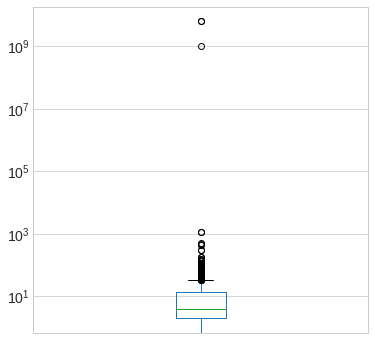

In [ ]:
fig = plt.figure(figsize=(6, 6))
axis = fig.gca()

patient_info.boxplot('contact_number')

axis.get_xaxis().set_visible(False);
axis.set_yscale('log')

It looks like there are some faulty entries in the data - having contact with billion of people seems impossible.

In [ ]:
faulty_values = patient_info['contact_number'] >= 10000
patient_info.loc[faulty_values, :]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
818,1000000819,unknown,unknown,Korea,Seoul,Eunpyeong-gu,unknown,NaN,1.000001e+09,NaN,2020-05-27,NaN,NaN,released
5109,6100000097,female,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,NaN,6.100000e+09,2020-03-26,2020-03-31,NaN,NaN,released
5110,6100000098,male,60s,Korea,Gyeongsangnam-do,Jinju-si,etc,6100000097,6.100000e+09,2020-03-28,2020-03-31,NaN,NaN,released


After inspecting the faulty values further, it seems that some of the *infected_by* values were erroneously entered to *contact_number* column. We will fix that and assign the respective *contact_number* values to NaN. 

In [ ]:
patient_info.loc[faulty_values, :] = patient_info.loc[faulty_values, :].bfill(axis=1)
patient_info.loc[faulty_values, ['contact_number']] = np.nan

Looking at the boxplot we also see that some people were in contact with a suspiciously large number of people - more than a 1000.

In [ ]:
above1000_contacts = patient_info['contact_number'] >= 1000
patient_info.loc[above1000_contacts, :]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1312,1100000001,male,10s,Korea,Busan,Dongnae-gu,Onchun Church,NaN,1091,NaN,2020-02-21,NaN,NaN,released
1463,1200000031,female,60s,Korea,Daegu,NaN,Shincheonji Church,NaN,1160,NaN,2020-02-18,NaN,NaN,isolated


These seem to be infection cases caused by the church gatherings. Since the number of people coming to church might be as high as 1000, we will consider this as a plausible number of contacts.

In [ ]:
Q1 = patient_info['contact_number'].quantile(0.25)
Q3 = patient_info['contact_number'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

upper_limit

32.0

More than 32 contacts can be considered as outliers. However, in big gathering cases, such as work, public events etc. people tend to meet a lot of people. Therefore, again, we will consider these to be valuable data.

### Adjust data types

Finally, where applicable, we will convert the columns with dates to date format for easier data handling.

In [ ]:
time['date'] = pd.to_datetime(time['date'], format='%Y-%m-%d')
time_age['date'] = pd.to_datetime(time_age['date'], format='%Y-%m-%d')
time_gender['date'] = pd.to_datetime(time_gender['date'], format='%Y-%m-%d')
time_province['date'] = pd.to_datetime(time_province['date'], format='%Y-%m-%d')
policy['start_date'] = pd.to_datetime(policy['start_date'], format='%Y-%m-%d')

# Exploratory data analysis

First, we will take a better look at the *patient_info* data. As the name implies, the data provide case information of a single subject basis.

In [ ]:
patient_info.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


The dataset is unique because it not only provides general demographic data but also gives information about the infection cause and source, number of contacts of the patient, illness history, outcome etc. We will use this information to get some insights into how the pandemic is spreading.

### Disease spread

Referring to the *infection_case*, we will find out what are the most common infection causes. 

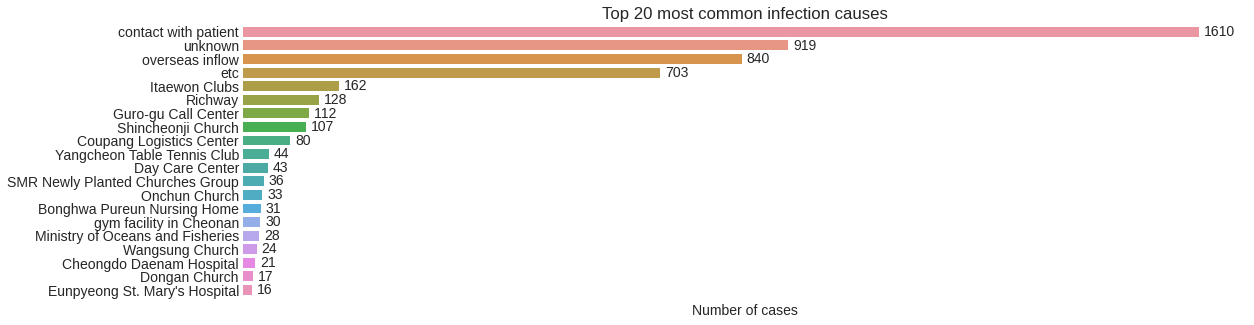

In [ ]:
cause_counts = patient_info['infection_case'].value_counts()
top20_infection_causes = pd.DataFrame(cause_counts[:20])

plt.figure(figsize=(18, 5))

axis = sns.barplot(y=top20_infection_causes.index,
                   x=top20_infection_causes['infection_case'],
                   orient='h')

sns.despine(bottom=True,
            left=True)

annotate_bars(axis)

axis.set_title('Top 20 most common infection causes')
axis.set_xlabel('Number of cases')
axis.set(xticklabels=[]) 
axis.grid(False)

From this graph, we can see that most of the individuals in the dataset got infected after getting in contact with other patients. There were 919 cases with no reason provided. The third major cause of infection is overseas inflow. The fourth most common reason is *etc* which most likely encompass reasons not covered by other common categories. The other cases were transmitted in places where big masses tend to gather, e.g., nightclubs in Itaewon, workplaces, churches.

Based on these common infection cases, we can reason that the most effective strategies for handling the pandemic would be:
- Isolating people who already got the disease.
- Minimizing the international travelling options.
- Preventing people gatherings indoors (at work, entertainment places, churches etc) 

## Contacts in different population groups

Number of contacts is an important factor determining faster disease spread. There might be some population groups that are more likely to meet more people. This could give us a better idea of which groups should be targeted when introducing the measures.

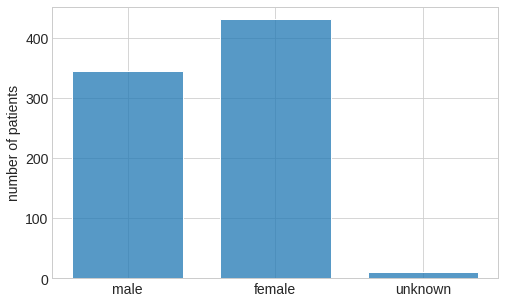

In [ ]:
patient_sex_contacts = patient_info[['sex', 'contact_number']]
patient_sex_contacts = patient_sex_contacts.dropna()

plot_distribution((8, 5), patient_sex_contacts, 'sex', 'number of patients')

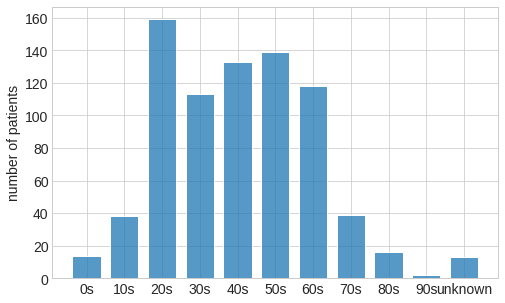

In [ ]:
patient_age_contacts = patient_info[['age', 'contact_number']]
patient_age_contacts = patient_age_contacts.dropna()

age_categories = ['0s', '10s', '20s' , '30s', '40s', '50s', 
                 '60s', '70s', '80s', '90s', 'unknown']

patient_age_contacts['age']= pd.Categorical(patient_age_contacts['age'], 
                                            age_categories)

patient_age_contacts.sort_values('age', inplace=True)

plot_distribution((8, 5), patient_age_contacts, 'age', 'number of patients')

Here, after grouping the data based on gender or age and dropping NaN values, I inspect the size of the groups to see if they are comparable. The group of people in their 90s is very small (only 2 observations) and, perhaps, provides aan insufficient representation of the group. Therefore, data from 90s will not be reported further in this section.

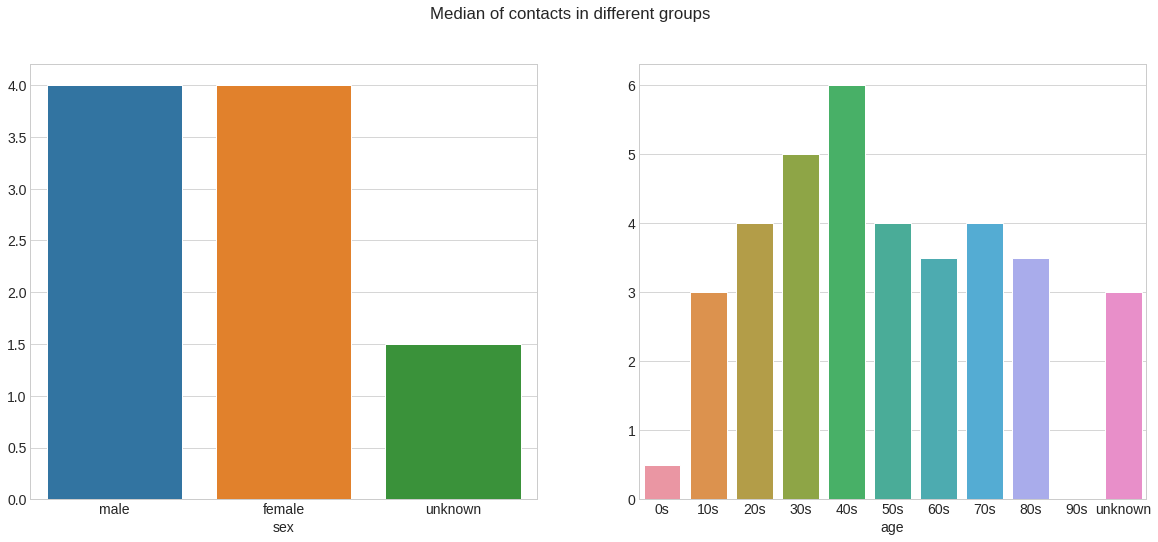

In [ ]:
patient_90s = patient_age_contacts['age'] == '90s'
patient_age_contacts.drop(patient_age_contacts[patient_90s].index, inplace=True)

fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(20, 8))

sns.barplot(x='sex',
            y='contact_number',
            data=patient_sex_contacts,
            estimator=np.median,
            ax=axes[0],
            ci=None);

sns.barplot(x='age',
            y='contact_number',
            data=patient_age_contacts,
            estimator=np.median,
            ax=axes[1],
            ci=None);

plt.suptitle('Median of contacts in different groups')

for axis in axes: 
  axis.set_ylabel(None);

While there is no noticeable difference in median contact number between males and females. People in their 40s have the highest median contact numbers. Possibly, this could be explained by the fact that South Korea's average person age of the working class is [42.9](https://www.statista.com/statistics/641956/south-korea-average-age-employees/) years. A lot of these infections might happen at work and, parhaps, might have been hard to avoid. Therefore, reducing the contact at the workplace should be an important step towards case reduction.

## Infections and outcomes

Next, we will inspect the infection and mortality rates across different age groups.

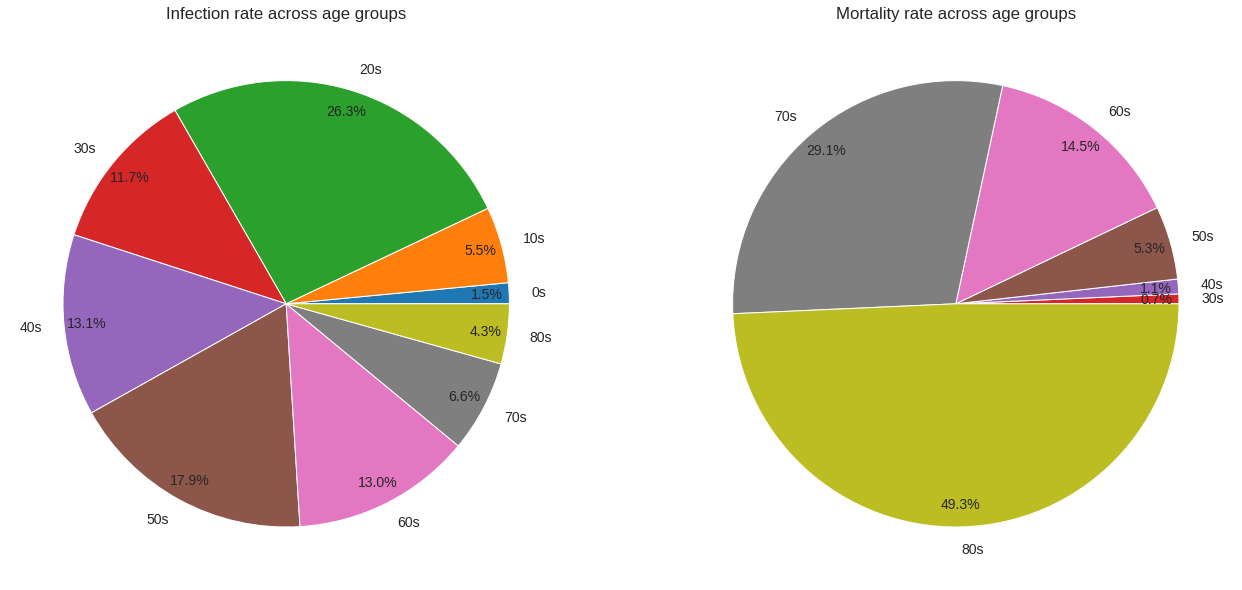

In [ ]:
latest_date = time_age['date'] == time_age['date'].max()
age_data = time_age.loc[latest_date, ['age', 'confirmed', 'deceased']] \
           .set_index('age')

axes = age_data.plot(kind='pie',
                     figsize=(22, 20), 
                     subplots=True, 
                     legend=False, 
                     autopct=show_nonzero, 
                     pctdistance=0.9);

axes[0].set_title('Infection rate across age groups')
axes[1].set_title('Mortality rate across age groups')

for axis in axes:
  axis.get_yaxis().set_visible(False);

Based on the final date observation reported in the *time_age* dataset, South Korean citizens in their 20s have the highest infection rate, while mortality rates are highest for patients in their 80s and the mortality rate seems to increase with age. Furthermore, there were no deaths reported for people younger than 30 years. 

However, we should keep in mind that in general there is a different distribution of age groups in South Korea. We will take this into account by calculating the proportion of infected people in each age group to the overall number of people in the same age group in the population. Essentially, it will represent the chance of getting infected based on age.

For this purpose, we will import [data](https://www.populationpyramid.net/republic-of-korea/2019/) on age statistics of South Korea in 2019.

In [ ]:
korea_population_age = pd.read_csv('Republic of Korea-2019.csv')
korea_population_age.drop(korea_population_age.tail(3).index,inplace=True)
korea_population_age

,Age,M,F
0,0-4,1011337,958165
1,5-9,1166864,1104519
2,10-14,1182869,1105654
3,15-19,1353570,1244531
4,20-24,1747374,1578873
5,25-29,1856271,1615387
6,30-34,1756422,1581655
7,35-39,2001445,1857327
8,40-44,2046048,1944249
9,45-49,2205709,2134000


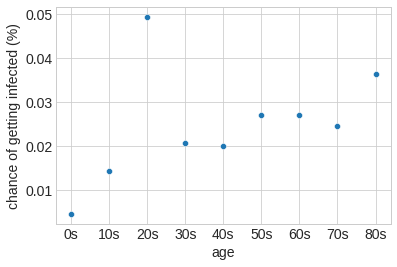

In [ ]:
age_data['korea_population_age'] = korea_population_age \
                                  .groupby(korea_population_age.index // 2) \
                                  .sum() \
                                  .sum(axis=1) \
                                  .values

age_data['infection_chance'] = age_data['confirmed'] \
                              /age_data['korea_population_age']*100

axis = sns.scatterplot(x=age_data.index, y='infection_chance', data=age_data)

axis.set_ylabel('chance of getting infected (%)');

Considering the overall composition of the population, youth in their 20s has the highest chance of getting infected. Interestingly, although the elderly (80s) take up only 4.3% of the overall infection cases, they do have a relatively higher chance of getting infected in comparison to other age groups.

Similarly, we will further try to estimate the chance of being deceased after getting infected based on the patient's age.

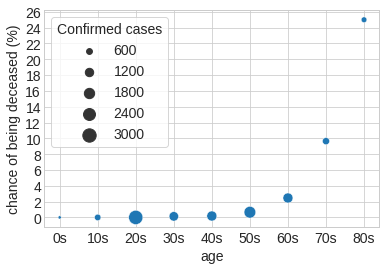

In [ ]:
age_data['decease_chance'] = age_data['deceased']/age_data['confirmed']*100

axis = sns.scatterplot(x=age_data.index, 
                       y='decease_chance', 
                       data=age_data, 
                       size='confirmed', 
                       sizes=(10, 200))

axis.legend(title='Confirmed cases', frameon=True)

axis.set_ylabel('chance of being deceased (%)');
axis.set_yticks(np.arange(0, 27, 2));

The chance of being deceased increases with age: we see that people in their 80s have 25% chance of dying after being infected.

Overall, this analysis implies that while younger people (20s) seems to get infected more, the most vulnerable group seems to be the elderly, particularly people in their 80s. Hence, special care should be takne to treat and limit the contact with the elderly, especially protect them with meeting the youth (20s). Effective measures to achieve this goal could be:
- Prohibit or minimize visitors at elderly nursery homes
- Organize university courses online
- Close youth entertainment and gathering places

## Daily trends and policies

The provided data also allows looking at the changes in time. The *time* dataframe contains time series of daily updates of COVID-19 status in South Korea.

We will first plot the accumulated sum of *confirmed*, *released* and *deceased* cases across the time of data collection.

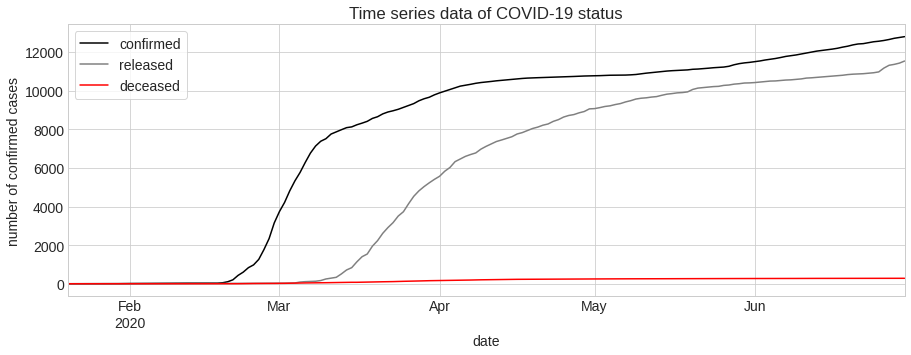

In [ ]:
fig = plt.figure(figsize=(15, 5))
axis = fig.gca()

time[['date', 'confirmed', 'released', 'deceased']].plot(x='date',
                                                         color=['black', 
                                                                'grey', 
                                                                'red'],
                                                         ax=axis);

axis.set_title('Time series data of COVID-19 status');
axis.legend(frameon=True);

axis.set_ylabel('number of confirmed cases');

We see that the confirmed cases started to rise rapidly in the middle of February, reached a plateau around the middle of April and then started to rise again from the middle of May. In the middle of May the number of released cases came closest to the infection rate, which means that most of those infected recovered at that point in time. Deceased cases increased, but stayed relatively low. The provided data shows the cumulative sum of cases, we will derive a new variable, daily cases to see the change of the cases better.




In [ ]:
time['daily_confirmed'] = time['confirmed'].diff().fillna(0)
time['daily_released'] = time['released'].diff().fillna(0)
time['daily_deceased'] = time['deceased'].diff().fillna(0)

Next, we would like to see which of the policies released throughout the time of data collection were most influential changing the case number. For this purpose, we will look at the policies that have been released during the time of data collection.

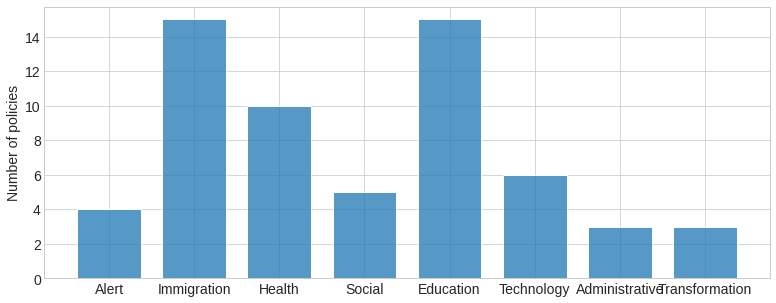

In [ ]:
plot_distribution((13, 5), policy, 'type', 'Number of policies')

Most of them concerned immigration and education.

In the next visualization, we will inspect the timeline of released policies and their relation to the daily new cases.


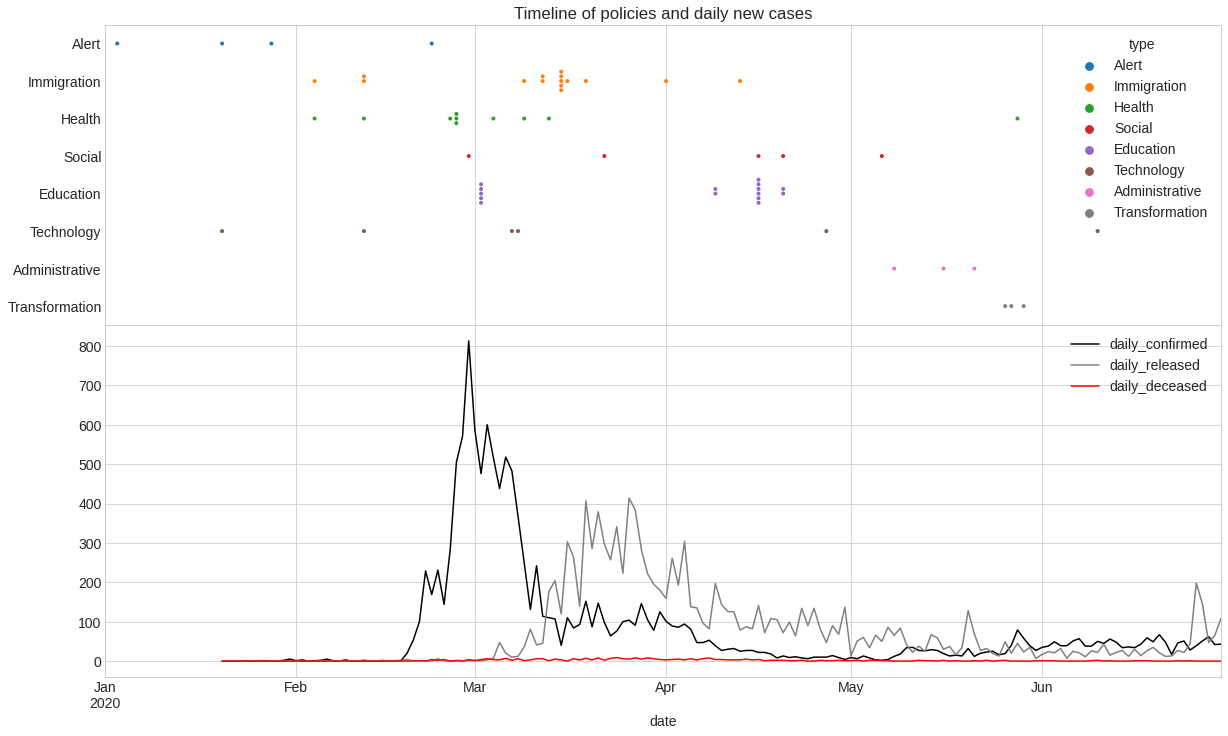

In [ ]:
daily_cases = time[['date', 
                    'daily_confirmed', 
                    'daily_released', 
                    'daily_deceased']]

fig = plt.figure(figsize=(20, 12))
grid = mpl.gridspec.GridSpec(2, 1, height_ratios=[2.3, 2.7]) 

axis0 = plt.subplot(grid[0])
sns.swarmplot(x='start_date', 
              y='type', 
              hue='type', 
              orient="h", 
              data=policy, 
              ax=axis0, 
              size=4)

axis1 = plt.subplot(grid[1])
daily_cases.plot(x='date', color=['black', 'grey', 'red'], ax=axis1)

axis0.set_title('Timeline of policies and daily new cases');

axis0.set_ylabel(None);
axis1.set_ylabel(None);

time_range = [dt.date(2020, 1, 1), dt.date(2020, 6, 30)]
axis0.set_xlim(time_range)
axis1.set_xlim(time_range)

plt.setp(axis0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

There are 2 notable decrease periods (negative slope) in daily confirmed cases: from March 28th and April 19th and from March 28th to April 15th (precise dates were determined by checking local minima and maxima). It means that the policies released before this time (most from health, education and immigration categories) were influential. Since some time is required for the policies to take the effect, we will approximate this time to be around 10 days.

In [ ]:
delay = 10
decrease1_start = dt.date(2020, 2, 28) - dt.timedelta(days=delay)
decrease1_end = dt.date(2020, 3, 15) - dt.timedelta(days=delay)

policy.loc[(policy['start_date'].dt.date >= decrease1_start) \
           & (policy['start_date'].dt.date <= decrease1_end), :]

,country,type,gov_policy,detail,start_date
policy_id,,,,,
4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23
22,Korea,Health,Emergency Use Authorization of Diagnostic Kit,3rd EUA,2020-02-27
23,Korea,Health,Emergency Use Authorization of Diagnostic Kit,4th EUA,2020-02-27
25,Korea,Health,Drive-Through Screening Center,by Local Government,2020-02-26
26,Korea,Health,Drive-Through Screening Center,Standard Operating Procedures,2020-03-04
27,Korea,Health,Mask Distribution,Public-Sale,2020-02-27
29,Korea,Social,Social Distancing Campaign,Strong,2020-02-29
34,Korea,Education,School Closure,Daycare Center for Children,2020-03-02
35,Korea,Education,School Opening Delay,Kindergarten,2020-03-02


In [ ]:
decrease2_start = dt.date(2020, 3, 28) - dt.timedelta(days=delay)
decrease2_end = dt.date(2020, 4, 19) - dt.timedelta(days=delay)

policy.loc[(policy['start_date'].dt.date >= decrease2_start) \
           & (policy['start_date'].dt.date <= decrease2_end), :]

,country,type,gov_policy,detail,start_date
policy_id,,,,,
17,Korea,Immigration,Special Immigration Procedure,from all the countries,2020-03-19
18,Korea,Immigration,Mandatory 14-day Self-Quarantine,from all the countries,2020-04-01
30,Korea,Social,Social Distancing Campaign,Strong,2020-03-22
39,Korea,Education,School Opening with Online Class,High School (3rd grade),2020-04-09
42,Korea,Education,School Opening with Online Class,Middle School (3rd grade),2020-04-09


It appears that the encouragement of easier testing options, masks and social distancing campaign were effective. Furthermore, quarantine and school measures were important.

Also, we will inspect how the infection number varied in time for different age groups: the different measures target different age groups and, hence, might have caused variations only in some age groups.

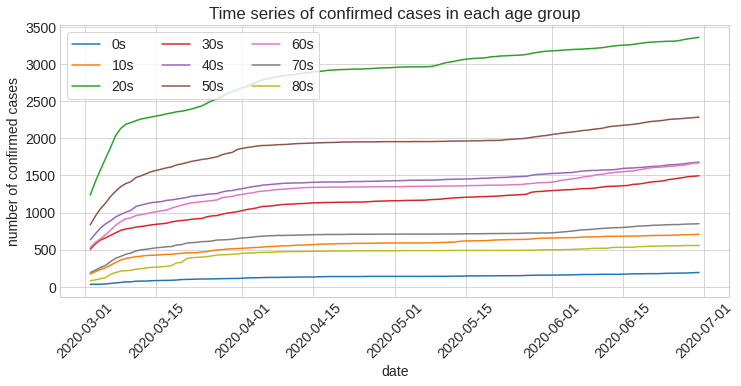

In [ ]:
plt.figure(figsize = (12, 5))
axis = sns.lineplot(data = time_age,
                  x='date',
                  y='confirmed',
                  hue = 'age')

locs, labels = plt.xticks()
plt.title('Time series of confirmed cases in each age group')
plt.setp(labels, rotation=45);

axis.legend(frameon=True, ncol=3);
axis.set_ylabel('number of confirmed cases');

We see that while there are some slight variations, the proportion of total infected people per age group remains rather stable throughout the time of data collection which further might imply that while some of the policies target specific age group 

## Geographical distribution

In the next section, we will inspect which provinces of South Korea were affected most and what could be possible factors for that.

First, we will illustrate the accumulated number of cases in each province as a map. For this purpose, we will make use of the shape map of South Korea's administrative units.

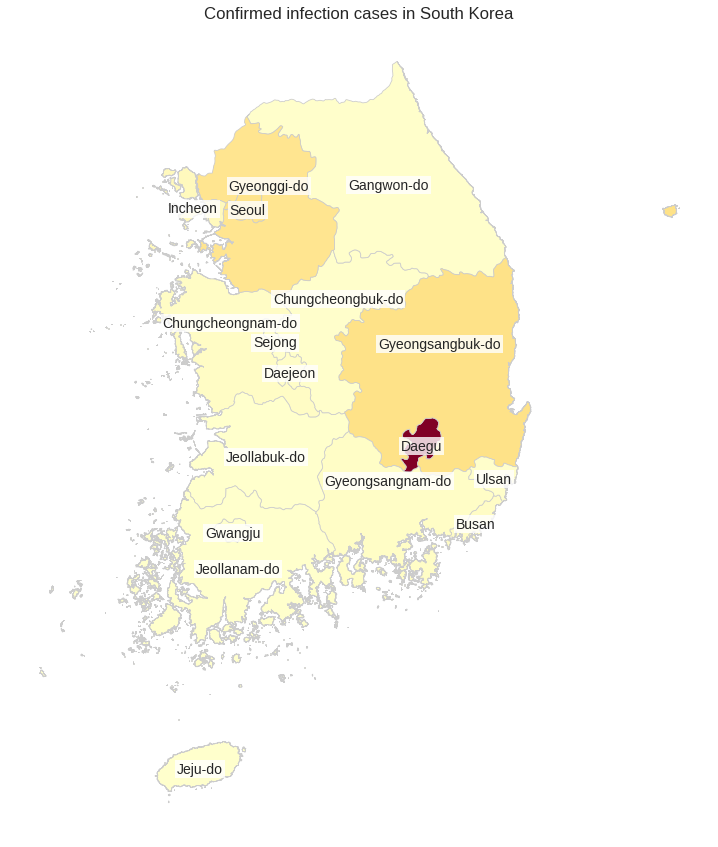

In [ ]:
latest_date = time_province['date'] == time_province['date'].max()
province_cases = time_province.loc[latest_date, ['province', 'confirmed']]
province_cases.sort_values(by=['province'], inplace=True)

province_shape = gpd.read_file('KOR_adm1.shp')
province_shape.rename(columns={'NAME_1': 'province'}, inplace=True)
province_shape['province'].replace({'Jeju':'Jeju-do'}, inplace=True)

province_map_cases = province_shape.set_index('province') \
                     .join(province_cases.set_index('province'))

vmin, vmax = 200, 300
fig, ax = plt.subplots(1, figsize=(15, 15))
province_map_cases.plot(column='confirmed',
                        cmap='YlOrRd',
                        linewidth=0.8,
                        ax=ax,
                        edgecolor='0.8')

province_shape['coords'] = province_shape['geometry'] \
                           .apply(lambda x: x.centroid.coords[:])

province_shape['coords'] = [coords[0] for coords in province_shape['coords']]

parameters = {'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}

# Adjust overlapping labels
for idx, row in province_shape.iterrows():
  if 'Chu' in row['province']: 
    ax.text(row.coords[0], row.coords[1]+0.2,
            s=row['province'], 
            horizontalalignment='center', 
            verticalalignment='top', 
            bbox=parameters)
    
  elif 'Gyeon' in row['province']:
    ax.text(row.coords[0], row.coords[1]+0.25, 
            s=row['province'], 
            horizontalalignment='center', 
            verticalalignment='top', 
            bbox=parameters)
    
  else:
    ax.text(row.coords[0], row.coords[1]+0.03, 
            s=row['province'], 
            horizontalalignment='center', 
            verticalalignment='top', 
            bbox=parameters)

ax.axis('off')
ax.set_title('Confirmed infection cases in South Korea');

The most affected provinces seem to be Daegu, Seoul, Gyeonggi-do, Gyeongsangbuk-do. Daegu and Seoul are [metropolian cities](https://en.wikipedia.org/wiki/List_of_special_cities_of_South_Korea).

Next, we are interested in whether there are some factors associated with the infection rate in the provinces. We will create new features for this analysis. So far, we have figured out that people tend to get infected in large gathering places, e.g., hospitals. We can speculate that more units that gather a lot of people could be associated with infection rates. We will extract these from the *region* dataset.

In [ ]:
region = region[:-1]
region_only = region['province'] == region['city']

province_features = region.loc[region_only,  ['province', \
                                              'elementary_school_count', \
                                              'kindergarten_count', \
                                              'university_count', \
                                              'nursing_home_count']]

province_features

,province,elementary_school_count,kindergarten_count,university_count,nursing_home_count
0,Seoul,607,830,48,22739
26,Busan,304,408,22,6752
43,Daegu,229,355,11,5083
52,Gwangju,155,312,17,2852
58,Incheon,250,403,7,4497
69,Daejeon,148,260,15,2984
75,Ulsan,119,200,4,1801
81,Sejong,48,60,3,491
82,Gyeonggi-do,1277,2237,61,20491
114,Gangwon-do,349,368,18,2519


Other infections were related to overseas inflow and workplace. Hence, we will add general people density, migration factors and number of indutsial buildings to the analysis using data gathered from [Statista website
](https://www.statista.com/) and check their correlation with the overall confirmed infection cases.

In [ ]:
province_demographics = pd.read_csv('Province_demographics.csv')
province_features = province_features.set_index('province') \
                    .join(province_demographics.set_index('province')) \
                    .join(province_cases.set_index('province'))

province_features.corr().loc[:, ['confirmed']]

,confirmed
elementary_school_count,0.080984
kindergarten_count,0.111802
university_count,0.086281
nursing_home_count,0.201593
population (mln),0.170431
density,0.178311
net internal migration,-0.157775
number of registered foreigners,0.111219
industrial buildings,0.095806
confirmed,1.000000


Contrary to our guess, no strong correlations were observed. It means that these characteristics alone do not associate with the infection cases well.



# Conclusion: South Korea

In conclusion, the analysis reported here provided us with the following insights and suggestions for fighting pandemia in Lithuania.
1. Based on the common causes, it is extremely important to identify and isolate already infected patients and handle the overseas inflow properly.
  - Based on South Korea’s example, introducing heavy testing, quarantining and social distancing could be effective.
2. Other cases emerged from places where people gather and meet in close proximity, e.g., church, clubs etc.
  - It could be achieved by closing non-essential destinations: entertainment, dinning places, concert halls.
3. COVID-19 does not spread nor affect different age groups equally. Proportionally, people in their 20s and 80s are more likely to get infected, even though those in the age range 40-50 seem to have more contacts. 
  - Hence, we recommend limiting student contact in classes, student houses etc in addition to the measures mentioned above. 
  - Furthermore, it is important to protect the elderly: limit or introduce testing of visitors/staff at the nursing home and, in general, take more precautions in their care.
4. While there are some variations in the patient distribution geographically, we did not discover demographic factors associated more/less infection rates.
  - Therefore, we recommend applying measures country-wise instead of region-wise.

# COVID-19 situation in Lithuania

Next, we will look at the COVID-19 status in Lithuania in 2020 and 2021. We will make use of the data from [Official Statistics portal of Lithuania](https://open-data-ls-osp-sdg.hub.arcgis.com/datasets/ba35de03e111430f88a86f7d1f351de6_0/explore)

In [7]:
lt_cases = pd.read_csv('Agreguoti_COVID19_atvejai_ir_mirtys.csv', index_col=0)
lt_cases.head()

,municipality_name,date,sex,age_gr,new_cases,deaths_all,deaths_cov1,deaths_cov2,deaths_cov3
object_id,,,,,,,,,
1,Akmenės r. sav.,2022-01-05,Vyras,30-39,1,0,0,0,0
2,Akmenės r. sav.,2022-01-05,Vyras,40-49,1,0,0,0,0
3,Akmenės r. sav.,2022-01-05,Vyras,60-69,0,1,0,0,0
4,Akmenės r. sav.,2022-01-05,Moteris,20-29,1,0,0,0,0
5,Akmenės r. sav.,2022-01-05,Moteris,30-39,1,0,0,0,0


Similarly to the data from South Korea, we will analyze the cases and deaths in terms of municipalities, age and change in time. We will drop other features. The missing values will be checked as well.

In [ ]:
lt_cases.drop(columns=['sex', 'deaths_all', 'deaths_cov2', 'deaths_cov3'],
              inplace=True)

check_missing_values(lt_cases)
lt_cases['date'] = pd.to_datetime(lt_cases['date'], format = '%Y-%m-%d')

No missing values


There are no missing values in the data, but some of the observations are marked with *Nenustatyta* or *Cenzūruota*.

In [ ]:
lt_cases.loc[lt_cases['municipality_name'] == 'Nenustatyta', :].head()

,municipality_name,date,age_gr,new_cases,deaths_cov1
object_id,,,,,
1017,Nenustatyta,2022-01-04,70-79,0,0
1018,Nenustatyta,2022-01-04,Nenustatyta,2,0
1019,Nenustatyta,2022-01-04,30-39,1,0
1682,Nenustatyta,2022-01-03,Nenustatyta,4,0
2138,Nenustatyta,2022-01-02,Nenustatyta,1,0


Based on the data entry, the data from the same municipality and age tend to cluster together. Therefore, we will use *fill firward* method to adjust for these cases.

In [8]:
lt_cases.replace('Nenustatyta', method='ffill', inplace=True)
lt_cases.replace('Centenarianai', '100+', inplace=True)

lt_cases.loc[lt_cases['municipality_name'] == 'Cenzūruota', :].head()

,municipality_name,date,sex,age_gr,new_cases,deaths_all,deaths_cov1,deaths_cov2,deaths_cov3
object_id,,,,,,,,,
54,Cenzūruota,2022-01-05,Cenzūruota,0-9,19,0,0,0,0
55,Cenzūruota,2022-01-05,Cenzūruota,0-9,25,0,0,0,0
56,Cenzūruota,2022-01-05,Cenzūruota,0-9,9,0,0,0,0
57,Cenzūruota,2022-01-05,Cenzūruota,0-9,4,0,0,0,0
58,Cenzūruota,2022-01-05,Cenzūruota,0-9,11,0,0,0,0


*Cenzūruota* values seem to be assigned in cases when the data is provided for children up to 19 years old. Thus, it will be assumed that these values geographically follow the distribution of infections across the different municipalities. Hence, the values will be filled in with samples from municipalities, referring to the probability of known values.

In [ ]:
valid_values = lt_cases['municipality_name'] != 'Cenzūruota'
missing = lt_cases['municipality_name'] == 'Cenzūruota'
distribution = lt_cases.loc[valid_values, 'municipality_name'] \
               .value_counts(normalize=True)
               
lt_cases.loc[missing,'municipality_name'] = np.random.choice(distribution.index, 
                                                             size=missing.sum(), 
                                                             p=distribution.values)

Finally, the date format will be adjusted.

In [ ]:
lt_cases['date'] = pd.to_datetime(lt_cases['date'], format = '%Y-%m-%d')

## Daily status

First, we will see how the number of daily infection cases changed in time.

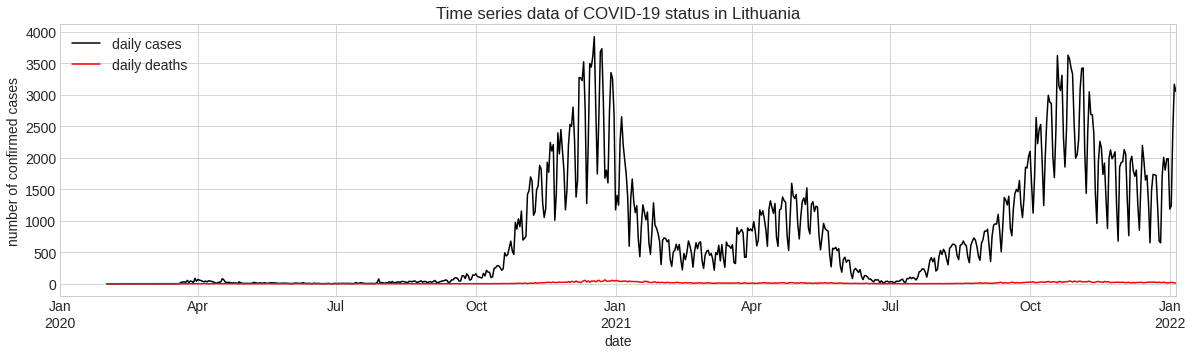

In [ ]:
daily_infections = lt_cases[['date', 'new_cases', 'deaths_cov1']] \
                   .groupby('date') \
                   .sum()

fig = plt.figure(figsize=(20, 5))
axis = fig.gca()

daily_infections.plot(color=['black', 'red'], ax=axis);

axis.set_title('Time series data of COVID-19 status in Lithuania');
axis.set_ylabel('number of confirmed cases');

axis.legend(frameon=True);axis.legend(['daily cases', 'daily deaths']);

time_range = [dt.date(2020, 1, 1), dt.date(2022, 1, 5)]
axis.set_xlim(time_range);

The rates of infections and deaths were relatively low in the beginning of 2020, which probably relates to the strict measures introduced by the government. The highest infection and death numbers occurred in 2021 December. Interestingly, we can also observe some seasonality in the data: cases started to rise in October both in 2020 and 2021.

## Cases in municipalities

Next, we will derive the municipalities most affected by the COVID-19. To determine the rate of infected people from each municipality, we will make use of the "Registrų centras" [data](https://www.registrucentras.lt/p/853) on the number of inhabitants in municipalities.

In [ ]:
municipality_population = pd.read_excel('2020_01_03_Gyventoju_skaičius_pagal_savivaldybes.xls')
municipality_population.head()

,Eil. nr.,Savivaldybės pavadinimas,Bendras gyventojų skaičius,Amžiaus grupės,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,0–6,7–17,Pensinio amžiaus
1,1.0,Akmenės r. sav.,21210.0,992,2027,5809
2,2.0,Alytaus m. sav.,55472.0,2691,5177,14209
3,3.0,Alytaus r. sav.,28543.0,1364,2795,6788
4,4.0,Anykščių r. sav.,25645.0,993,2046,7263


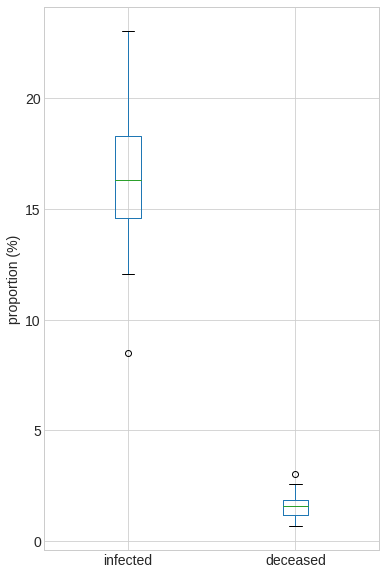

In [ ]:
municipality_all_cases = lt_cases.groupby('municipality_name').sum()
municipality_population = municipality_population.iloc[1:-1, 1:3]

municipality_cases = municipality_population \
                    .set_index('Savivaldybės pavadinimas') \
                    .join(municipality_all_cases)

municipality_cases['infected'] = municipality_cases['new_cases'] \
                                /municipality_cases['Bendras gyventojų skaičius'] \
                                *100

municipality_cases['deceased'] = municipality_cases['deaths_cov1'] \
                                /municipality_cases['new_cases'] \
                                *100


fig = plt.figure(figsize=(6, 10))
axis = municipality_cases.boxplot(column=['infected', 'deceased'])
axis.set_ylabel('proportion (%)');

The proportion of overall inhabitants infected and of those deceased after getting infected seems to be similar across the municipalities - only 2 outliers were detected. 

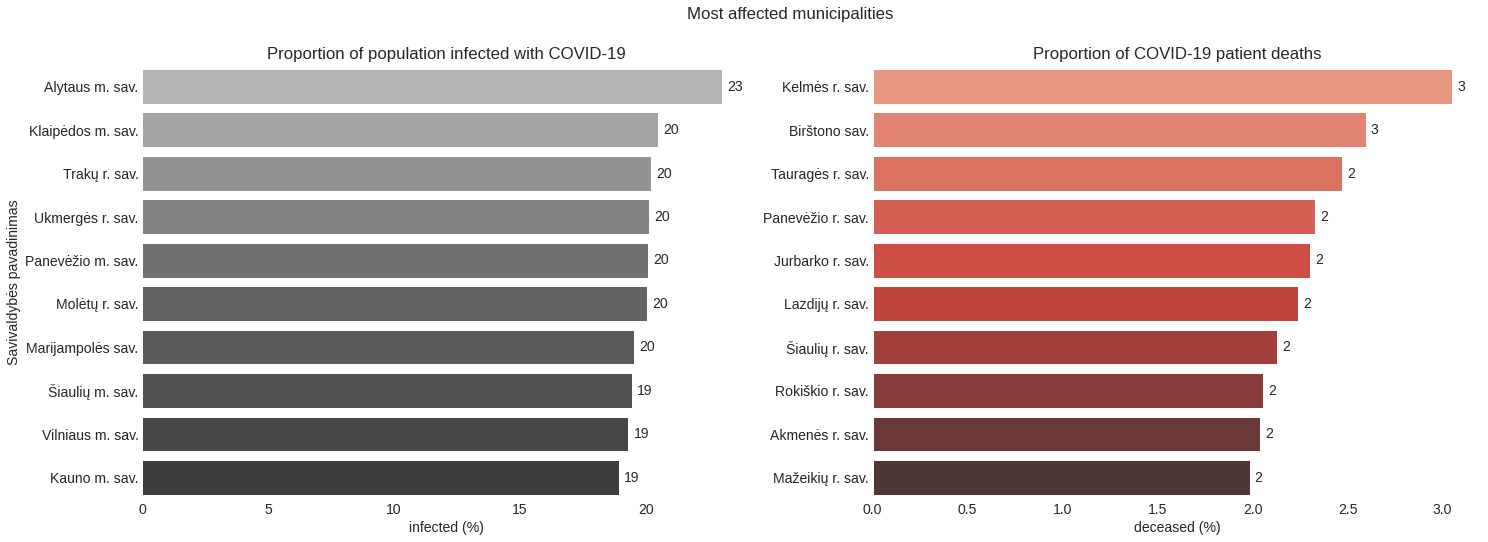

In [ ]:
most_cases_municipality = municipality_cases['infected'] \
                         .sort_values(ascending=False)[:10]
                          
most_deaths_municipality = municipality_cases['deceased'] \
                          .sort_values(ascending=False)[:10]

fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(24, 8))

axis0_bars = sns.barplot(y=most_cases_municipality.index,
                   x=most_cases_municipality,
                   orient='h',
                   ax=axes[0],
                   palette='Greys_d')

annotate_bars(axis0_bars)

axis1_bars = sns.barplot(y=most_deaths_municipality.index,
                   x=most_deaths_municipality,
                   orient='h',
                   ax=axes[1], 
                   palette='Reds_d')

annotate_bars(axis1_bars)

plt.suptitle('Most affected municipalities')
axes[0].set_title('Proportion of population infected with COVID-19')
axes[0].set_xlabel('infected (%)')

axes[1].set_title('Proportion of COVID-19 patient deaths')
axes[1].set_xlabel('deceased (%)')
axes[1].set_ylabel('')

sns.despine(bottom=True,left=True)
for axis in axes:
  axis.grid(False)

## Vaccination impact

By the end of 2020, vaccines against SARS-CoV-2 virus were released with a promise of becoming an effective tool to fight the COVID-19 pandemia by making the population more resistant to the virus. Let's see what was the impact of the vaccination.

For this purpose, we will first check the time range of the available data.

In [ ]:
print(lt_cases['date'].min())
print(lt_cases['date'].max())

2020-02-01 00:00:00
2022-01-05 00:00:00


We have data for almost 2 years of pandemia. We will separate the data to 2 categories: before and after vaccination has started. The first vaccines in Lithuania were administered [by the end of 2020](https://sam.lrv.lt/lt/naujienos/i-lietuva-atvyko-pirmoji-covid-19-vakcinu-siunta). Since there some time is required for the immunity to form after the second dose of vaccination, we will approximate that the vaccination effect started to take place in the beginning of March 2021 and lasted until the end of that year. For the comparison purpose, an equivalent timeline will be taken for the non-vaccination period in 2020.

In [ ]:
no_vaccine_period = (lt_cases['date'] > '2020-2-29') \
                    & (lt_cases['date'] <= '2021-1-1')

no_vaccination = lt_cases.loc[no_vaccine_period, :].groupby('age_gr').sum()

vaccine_period = (lt_cases['date'] > '2021-2-28') \
                 & (lt_cases['date'] <= '2022-1-1')
                 
vaccination = lt_cases.loc[vaccine_period, :].groupby('age_gr').sum()

vaccination - no_vaccination

,new_cases,deaths_cov1
age_gr,,
0-9,24234,1
10-19,38448,1
100+,-20,5
20-29,19007,13
30-39,33210,24
40-49,25470,102
50-59,13592,154
60-69,9669,298
70-79,6743,545


There were more infection and deaths cases in 2021 than in 2020.

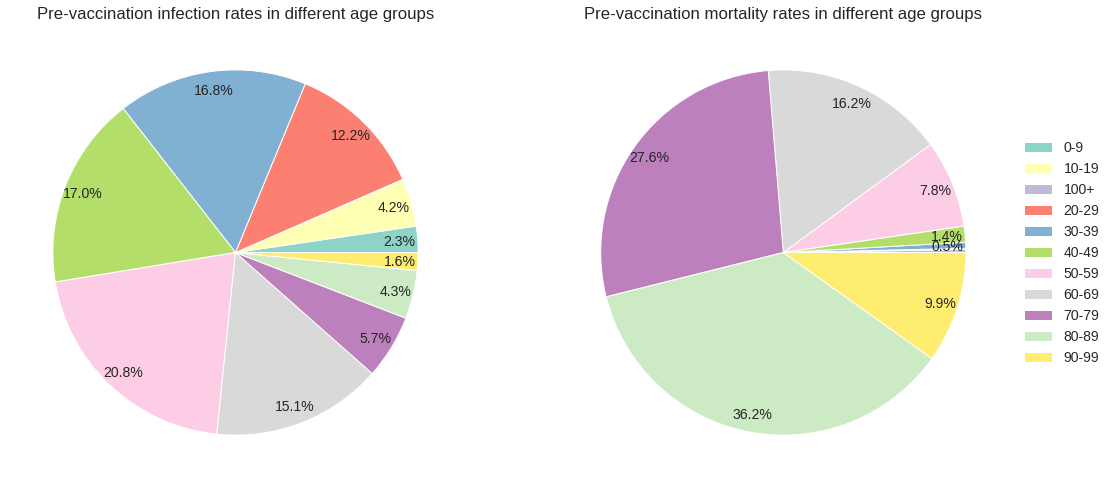

In [ ]:
plot_2pie_charts(no_vaccination, 
                 'Pre-vaccination infection rates in different age groups', 
                 'Pre-vaccination mortality rates in different age groups')

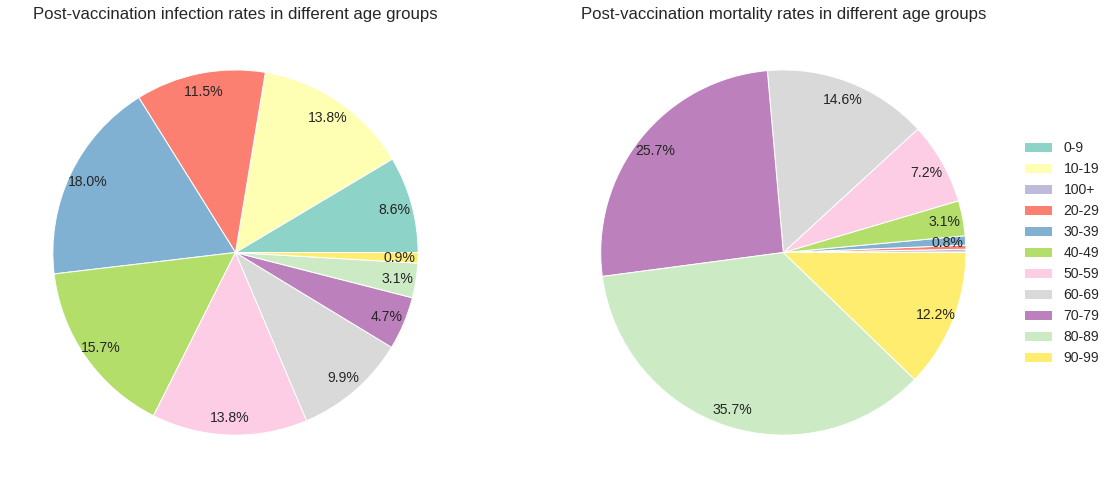

In [ ]:
plot_2pie_charts(vaccination, 
                 'Post-vaccination infection rates in different age groups', 
                 'Post-vaccination mortality rates in different age groups')

We see that the distribution of cases in age groups before and during the vaccination period changed: in 2021, more children got infected while ratios in all other age groups decreased. This can be explained by the fact that children vaccination started only in the winter of 2021. The mortality rate decreased slightly in most of the groups except 40s, 90s and 20s had some deaths.

It should be noted, that these results depend heavily on the [overall vaccination ratio in the country](https://koronastop.lrv.lt/lt/vakcina) as well as each age group. They should be considered for more conclusive results. Furthermore, the measures were less strict in 2021. It could also have been an influential factor for more infections.

# Conclusions: Lithuania

In addition to insights from South Korean data, based on the COVID-19 situation in Lithuania analysis, we can add:  
4. There seems to be a seasonality of the infection cases.
  - More infection cases in autumn and winter suggest that stronger measures should be introduced then.
5. The proportion of people infected and deceased is similar across different municipalities. Nevertheless, we visualized 10 that have the highest rates for each criterion. 
 - Further investigation could be done to determine why the situation is worse in those municipalities.
6. Based on a very rough approximation of vaccine efficiency in Lithuania in 2021, it seems that vaccines alone may not be sufficient for containing the pandemic. Alternatively, a larger proportion of the population needs to be vaccinated to see the effect.